In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D

In [2]:
# loading the inputs (out of https://www.kaggle.com/robikscube/hourly-energy-consumption?select=DOM_hourly.csv)
df = pd.read_csv('DOM_hourly.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])

target = 'DOM_MW'
cutoff = '2017-12-20'

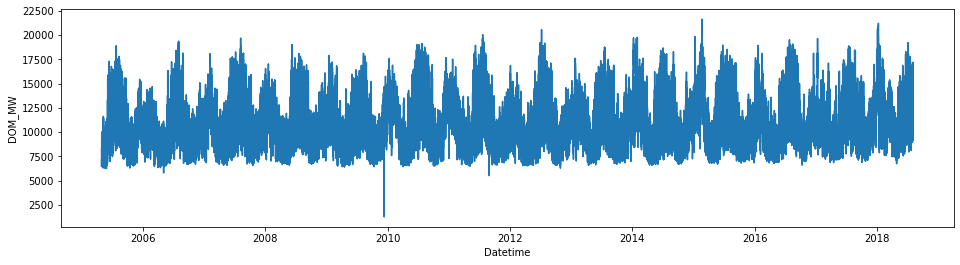

In [3]:
# plotting before scaling
plt.figure(figsize=(16,4))
sns.lineplot(x='Datetime', y=target, data=df)
plt.show()

In [4]:
# scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
df[target] = scaler.fit_transform(df[target].values.reshape(-1, 1))

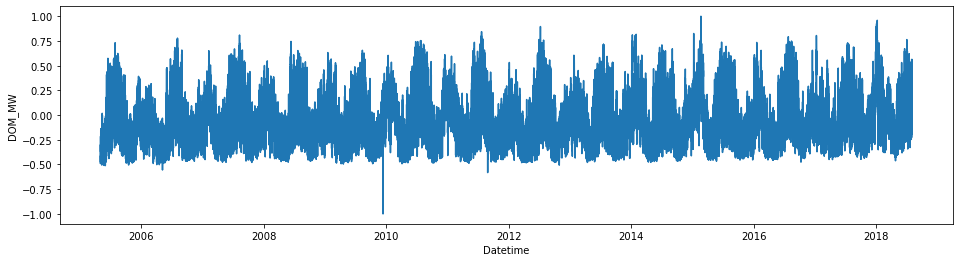

In [5]:
# plotting after scaling
plt.figure(figsize=(16,4))
sns.lineplot(x='Datetime', y=target, data=df)
plt.show()

In [6]:
# creating new columns with the past values (past X hours)
limit = 72
for i in range(1, limit+1):
    df[target + '_' + str(abs(i))] = df[target].shift(i).fillna(0)

In [7]:
# splitting between train and validation
df_train = df[df['Datetime']<cutoff].iloc[limit:]
df_validation = df[df['Datetime']>=cutoff]

In [8]:
df_train.head()

,Datetime,DOM_MW,DOM_MW_1,DOM_MW_2,DOM_MW_3,DOM_MW_4,DOM_MW_5,DOM_MW_6,DOM_MW_7,DOM_MW_8,...,DOM_MW_63,DOM_MW_64,DOM_MW_65,DOM_MW_66,DOM_MW_67,DOM_MW_68,DOM_MW_69,DOM_MW_70,DOM_MW_71,DOM_MW_72
72,2005-12-28 01:00:00,-0.141975,-0.189332,-0.117855,-0.050593,-0.012256,-0.001275,0.017649,0.002941,-0.083145,...,-0.052554,-0.084910,-0.123443,-0.169624,-0.205804,-0.227473,-0.236298,-0.240318,-0.233552,-0.202275
73,2005-12-28 02:00:00,-0.165310,-0.141975,-0.189332,-0.117855,-0.050593,-0.012256,-0.001275,0.017649,0.002941,...,-0.050887,-0.052554,-0.084910,-0.123443,-0.169624,-0.205804,-0.227473,-0.236298,-0.240318,-0.233552
74,2005-12-28 03:00:00,-0.160408,-0.165310,-0.141975,-0.189332,-0.117855,-0.050593,-0.012256,-0.001275,0.017649,...,-0.073929,-0.050887,-0.052554,-0.084910,-0.123443,-0.169624,-0.205804,-0.227473,-0.236298,-0.240318
75,2005-12-28 04:00:00,-0.151780,-0.160408,-0.165310,-0.141975,-0.189332,-0.117855,-0.050593,-0.012256,-0.001275,...,-0.110795,-0.073929,-0.050887,-0.052554,-0.084910,-0.123443,-0.169624,-0.205804,-0.227473,-0.236298
76,2005-12-28 05:00:00,-0.119816,-0.151780,-0.160408,-0.165310,-0.141975,-0.189332,-0.117855,-0.050593,-0.012256,...,-0.158643,-0.110795,-0.073929,-0.050887,-0.052554,-0.084910,-0.123443,-0.169624,-0.205804,-0.227473


In [9]:
# we need to convert the dataset to a numpy array instead of a pandas dataframe
# removing both the datetime and also the 'current' value
x_train = np.array(df_train.drop(['Datetime', target], axis=1))
y_train = np.array(df_train[target])

x_test = np.array(df_validation.drop(['Datetime', target], axis=1))
y_test = np.array(df_validation[target])

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [10]:
# ensuring we are using the GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3460083886622706677
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9104897474
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14653124412942009227
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [11]:
def create_model(kernel_size, lstm_dimensionality, dense_dimensionality, number_dense_layers):
    model = Sequential()
    model.add(Conv1D(filters=limit, kernel_size=kernel_size, strides=1, padding='causal', activation='relu', input_shape=[None, 1]))
    model.add(LSTM(lstm_dimensionality))

    for _ in range(number_dense_layers):
        model.add(Dense(dense_dimensionality))

    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])

    #model.summary()
    return model

In [14]:
# hyperparameters
kernel_size = limit
lstm_dimensionality = [limit, limit*2]
dense_dimensionality = [10, 50, 100]
number_dense_layers = [1, 4, 8]

batch_size = 512
epochs = 100

In [15]:
models = {}
for lstm_dim in lstm_dimensionality:
    for dense_dim in dense_dimensionality:
        for num_layers in number_dense_layers:
            display(f'LSTM dimensionality: {lstm_dim}, dense layer dimensionality: {dense_dim} @ {num_layers} dense layers.')
            model = create_model(kernel_size, lstm_dim, dense_dim, num_layers)
            model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
            models[(lstm_dim, dense_dim, num_layers)] = model

'LSTM dimensionality: 72, dense layer dimensionality: 10 @ 1 dense layers.'

'LSTM dimensionality: 72, dense layer dimensionality: 10 @ 4 dense layers.'

'LSTM dimensionality: 72, dense layer dimensionality: 10 @ 8 dense layers.'

'LSTM dimensionality: 72, dense layer dimensionality: 50 @ 1 dense layers.'

'LSTM dimensionality: 72, dense layer dimensionality: 50 @ 4 dense layers.'

'LSTM dimensionality: 72, dense layer dimensionality: 50 @ 8 dense layers.'

'LSTM dimensionality: 72, dense layer dimensionality: 100 @ 1 dense layers.'

'LSTM dimensionality: 72, dense layer dimensionality: 100 @ 4 dense layers.'

'LSTM dimensionality: 72, dense layer dimensionality: 100 @ 8 dense layers.'

'LSTM dimensionality: 144, dense layer dimensionality: 10 @ 1 dense layers.'

'LSTM dimensionality: 144, dense layer dimensionality: 10 @ 4 dense layers.'

'LSTM dimensionality: 144, dense layer dimensionality: 10 @ 8 dense layers.'

'LSTM dimensionality: 144, dense layer dimensionality: 50 @ 1 dense layers.'

'LSTM dimensionality: 144, dense layer dimensionality: 50 @ 4 dense layers.'

'LSTM dimensionality: 144, dense layer dimensionality: 50 @ 8 dense layers.'

'LSTM dimensionality: 144, dense layer dimensionality: 100 @ 1 dense layers.'

'LSTM dimensionality: 144, dense layer dimensionality: 100 @ 4 dense layers.'

'LSTM dimensionality: 144, dense layer dimensionality: 100 @ 8 dense layers.'

In [16]:
# retrieving the predictions
df_comparison = df_validation[['Datetime', target]].copy()
df_comparison[target] = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

for model in models:
    df_comparison[str(model)] = scaler.inverse_transform(models[model].predict(x_test)).flatten()

In [17]:
# calculating the metrics
df_results = pd.DataFrame(columns=['LSTM Dimensionality', 'Dense Dimensionality', 'Dense Layers', 'MAE', 'RMSE'])

for model in models:
    mae = mean_absolute_error(df_comparison[target], df_comparison[str(model)])
    rmse = sqrt(mean_squared_error(df_comparison[target], df_comparison[str(model)]))
    df_results = df_results.append({'LSTM Dimensionality': model[0], 'Dense Dimensionality': model[1], \
                                    'Dense Layers': model[2], 'MAE': mae, 'RMSE': rmse}, ignore_index=True)

for col in ['LSTM Dimensionality', 'Dense Dimensionality', 'Dense Layers']:
    df_results[col] = df_results[col].astype(int)

df_results

,LSTM Dimensionality,Dense Dimensionality,Dense Layers,MAE,RMSE
0,72,10,1,150.003162,311.382496
1,72,10,4,152.836195,302.296499
2,72,10,8,155.707232,305.047830
3,72,50,1,149.734664,308.144914
4,72,50,4,162.648862,306.645473
5,72,50,8,149.550243,302.376517
6,72,100,1,148.174270,311.532826
7,72,100,4,146.104930,296.255849
8,72,100,8,152.613498,305.735822
9,144,10,1,163.409139,332.474465


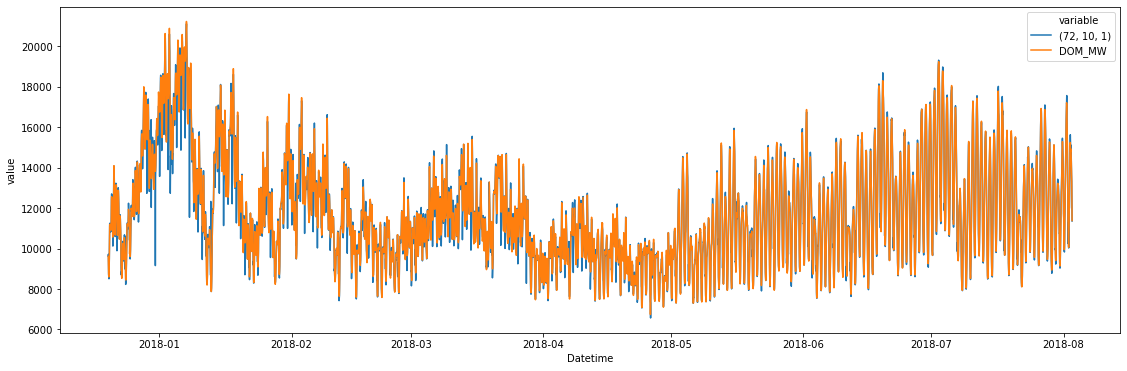

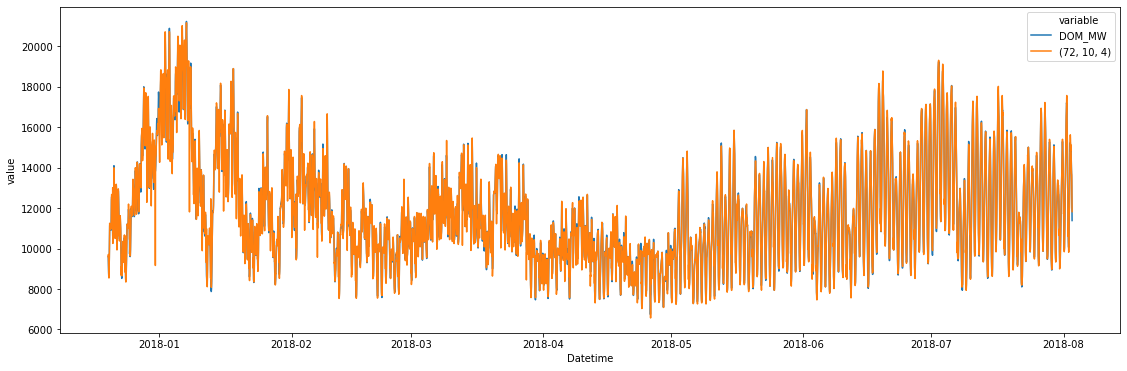

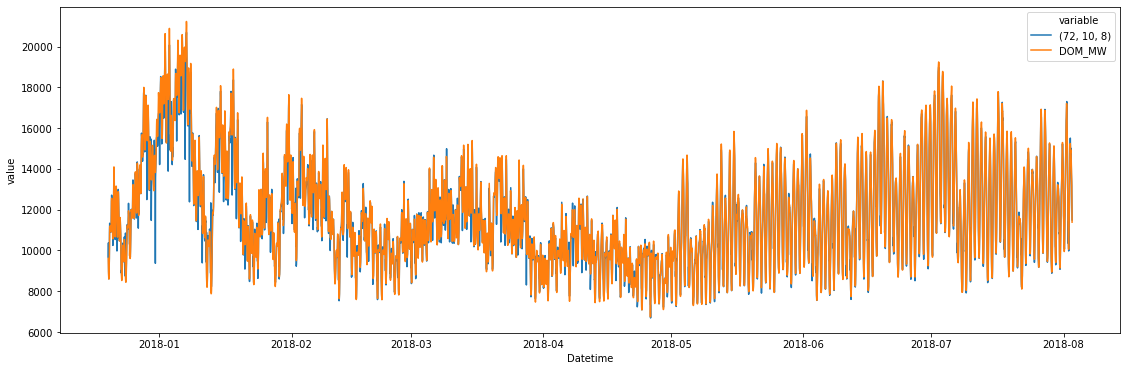

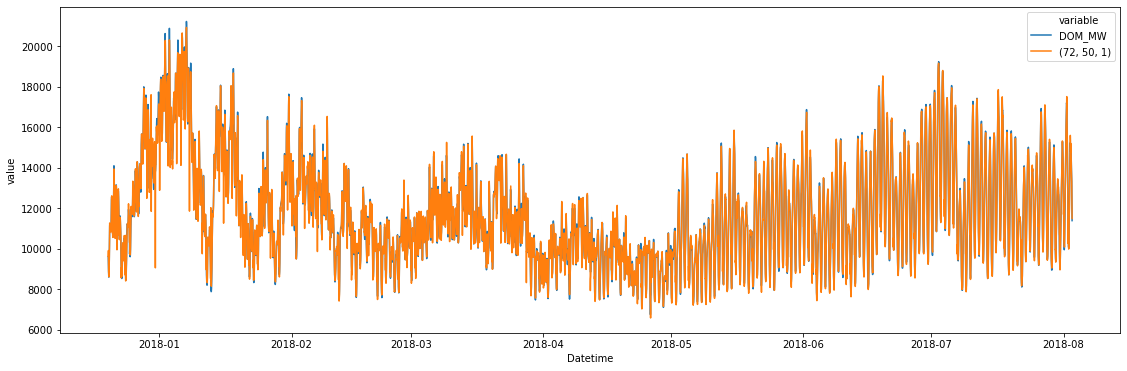

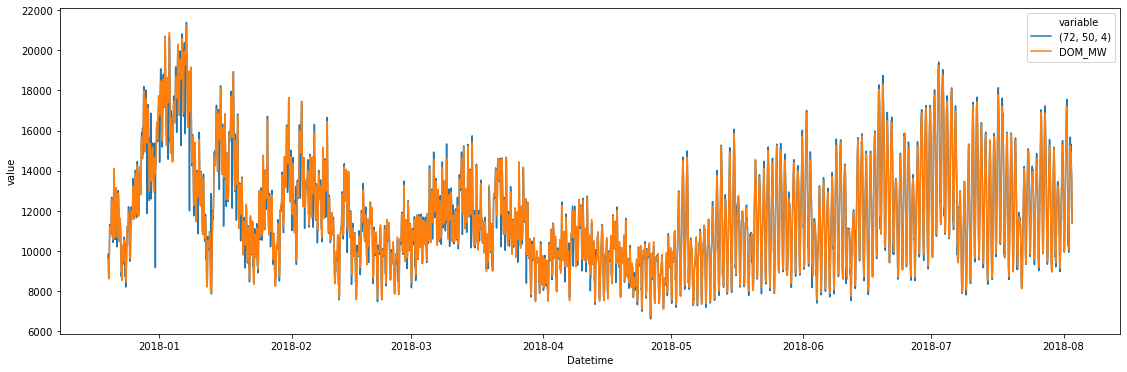

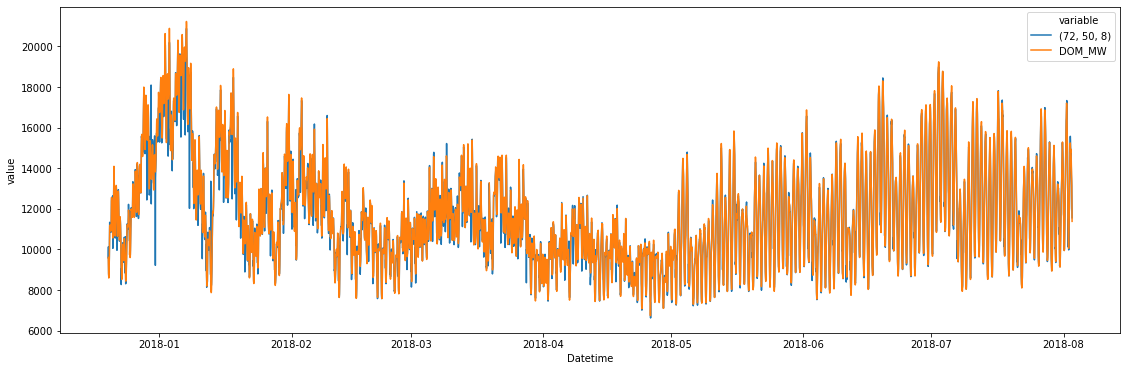

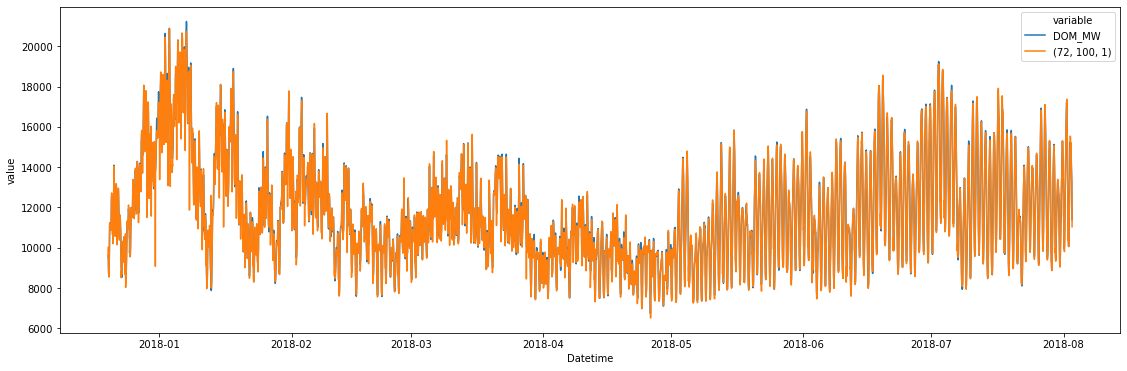

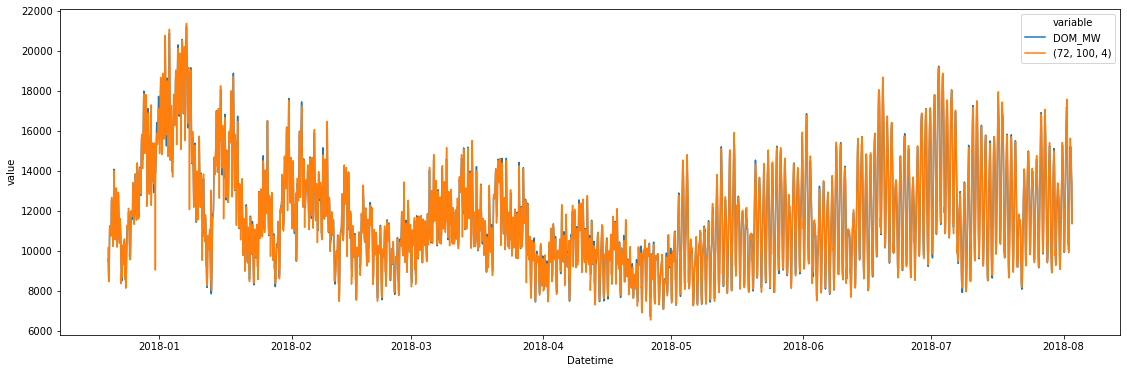

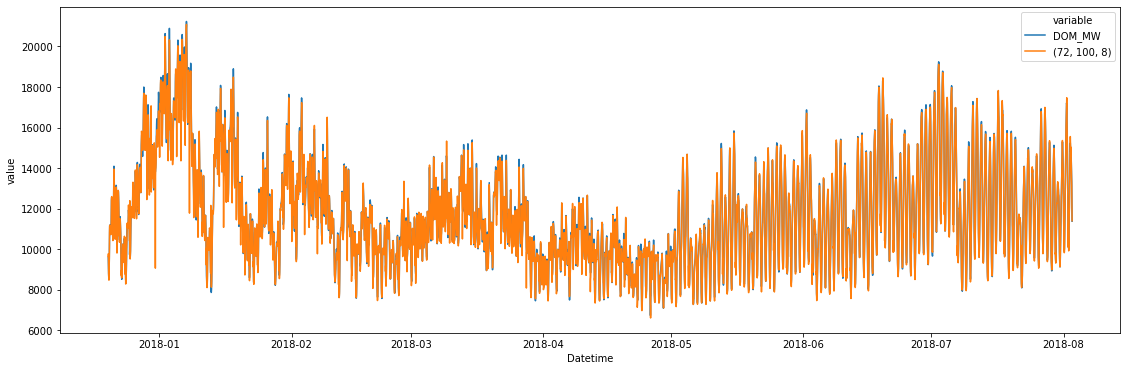

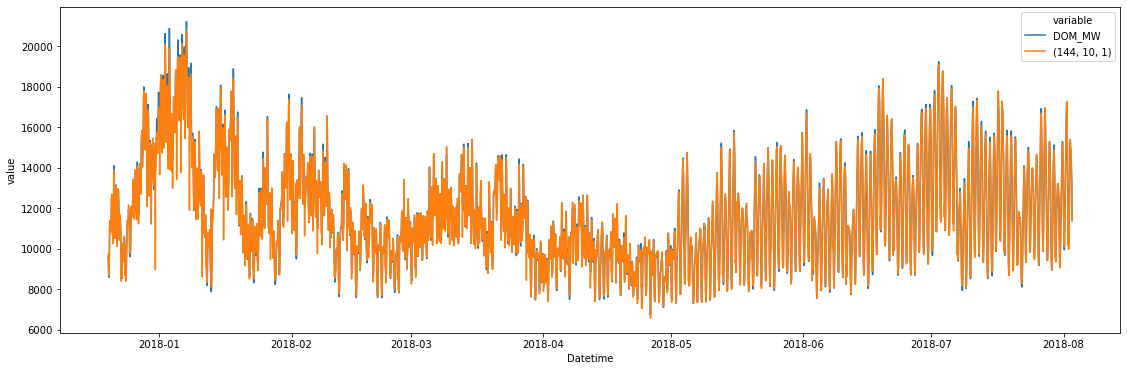

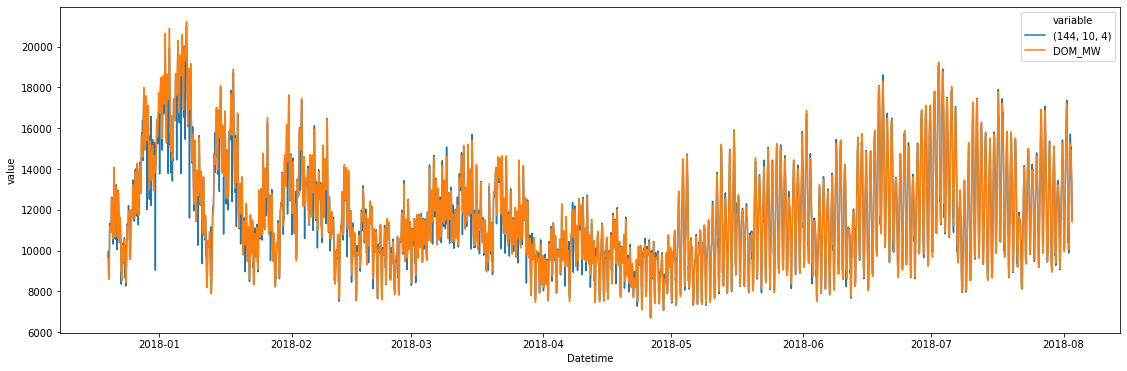

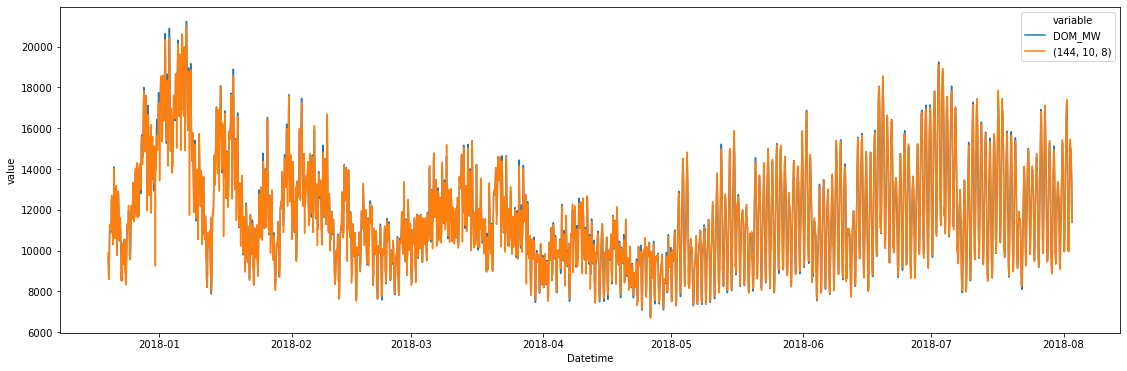

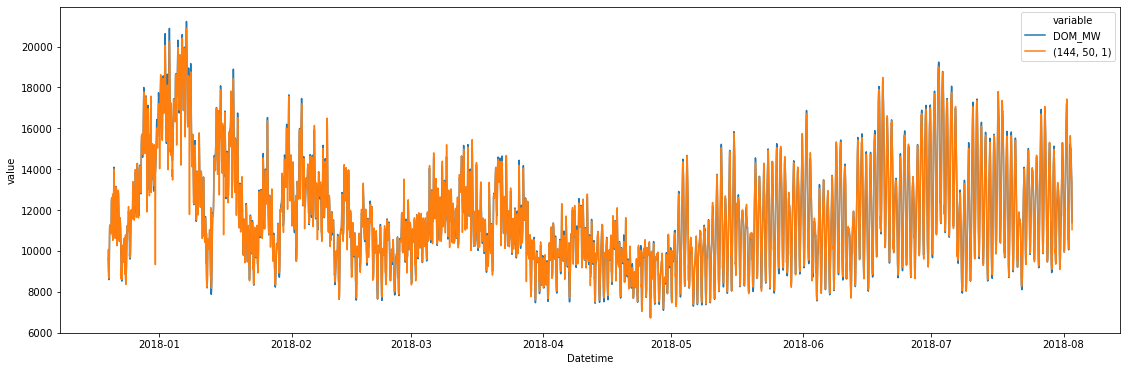

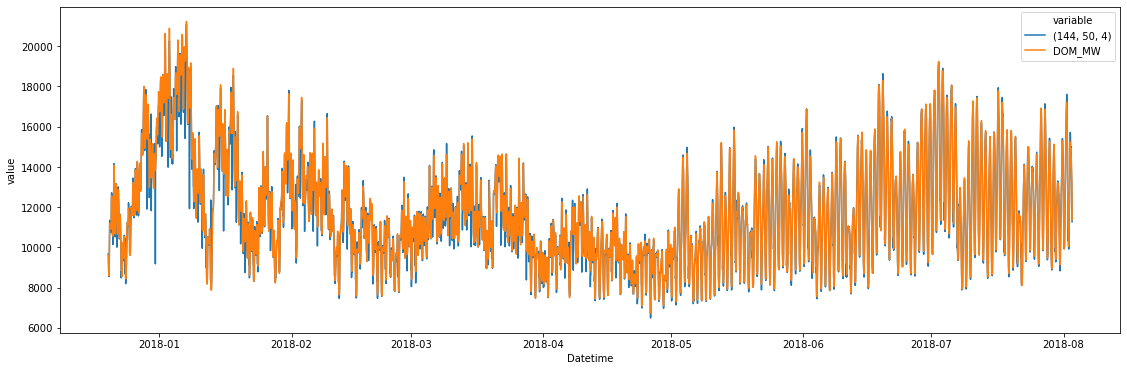

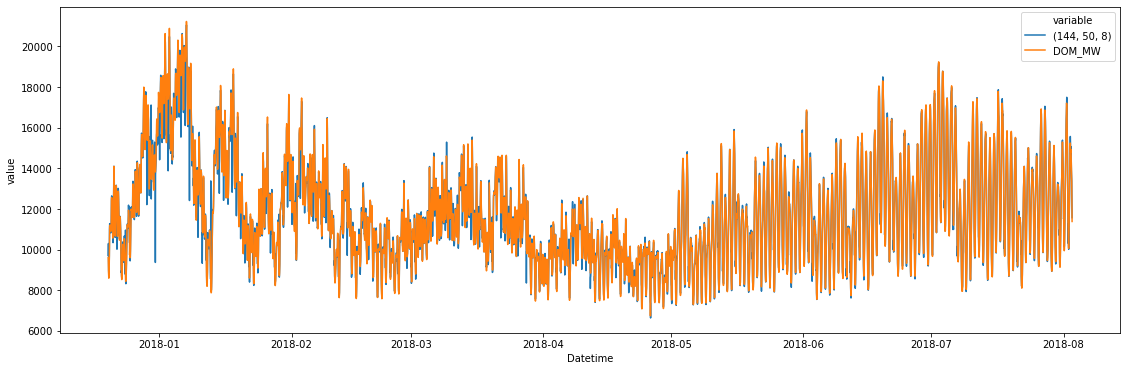

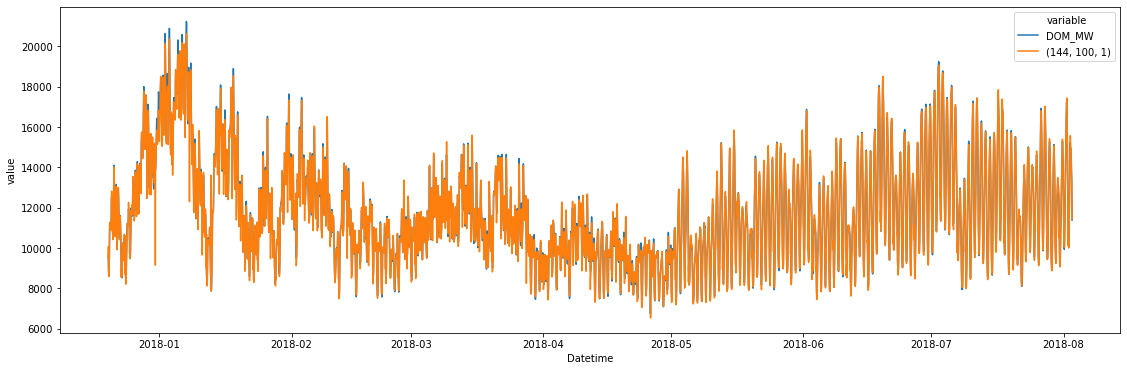

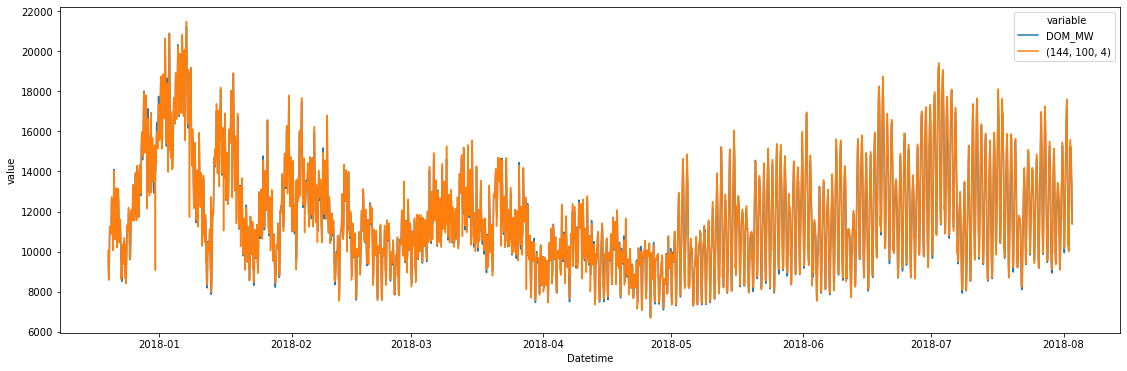

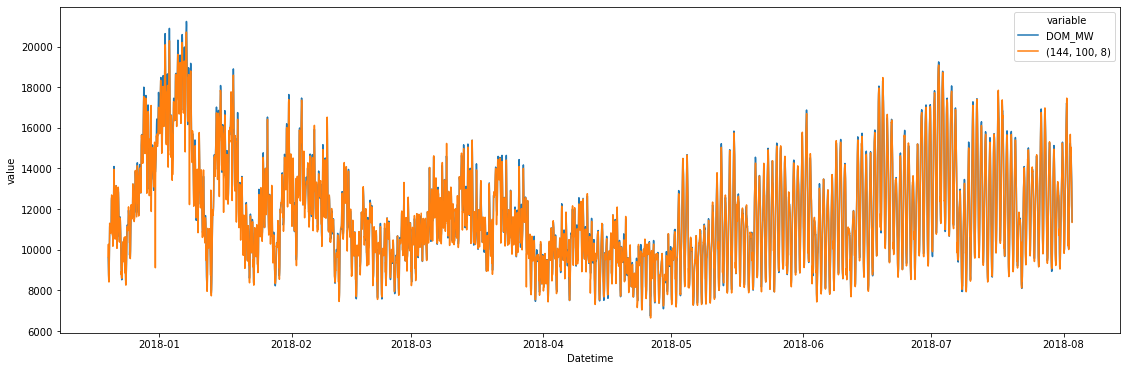

In [18]:
df_plot = pd.melt(df_comparison, id_vars=['Datetime'], value_vars=list(set(df_comparison.columns) - set(['Datetime'])))

for model in models:    
    plt.figure(figsize=(19, 6))
    sns.lineplot(x='Datetime', y='value', hue='variable', data=df_plot[(df_plot['variable']==target) | (df_plot['variable']==str(model))])
    plt.show()

In [19]:
df_results.to_csv('results.csv', encoding='utf-8', index=False)